# Atomic and magnetic PDF co-refinement using SrFit

This notebook provides an example of a simultaneous atomic + magnetic PDF refinement using SrFit. We will again use MnO as our test case.

#Long#:In the folder, there is an example_corefinement2.py.

### Import necessary modules

In [1]:
### Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt

from diffpy.mpdf import *
from diffpy.Structure import loadStructure
from scipy.optimize import least_squares
from diffpy.Structure.Parsers import getParser
from diffpy.srfit.pdf import PDFGenerator, PDFParser
from diffpy.srfit.fitbase import FitRecipe, FitResults
from diffpy.srfit.fitbase import Profile, FitContribution

### Set all plots to be inline
%matplotlib notebook

### Set up nuclear/magnetic PDF structures and calculators

In [3]:
# Files containing our experimental data and structure file
dataFile = "npdf_07334.gr"
structureFile = "MnO_R-3m.cif"

# load structure and space group from the CIF file
pcif = getParser('cif')
mno = pcif.parseFile(structureFile)

# prepare profile object with experimental data
profile = Profile()
parser = PDFParser()
parser.parseFile(dataFile)
profile.loadParsedData(parser)

# define range for pdf calculation
rmin = 0.01
rmax = 20
rstep = 0.01

# setup calculation range for the PDF simulation
profile.setCalculationRange(xmin=rmin, xmax=rmax, dx=rstep)

# prepare nucpdf function that simulates the nuclear PDF
nucpdf = PDFGenerator("nucpdf")
nucpdf.setStructure(mno)
nucpdf.setProfile(profile)

# prepare mpdf function that simulates the magnetic PDF

# Create the Mn2+ magnetic species. Note that we are using a different
# setting for the unit cell, so the propagation vector is actually (0,0,3/2)
# instead of the (1/2,1/2,1/2) as it was for the pseudocubic setting.
mn2p = MagSpecies(struc=mno, label='Mn2+', magIdxs=[0,1,2],
                  basisvecs=np.array([1,0,0]), kvecs=np.array([0,0,1.5]),
                  ffparamkey='Mn2')


# Create and prep the magnetic structure
mstr = MagStructure()
mstr.loadSpecies(mn2p)
mstr.makeAll()

# Set up the mPDF calculator.

mc=MPDFcalculator(magstruc=mstr,rmin=rmin,rmax=rmax,rstep=rstep)

#Long#:In introTutorial.ipynb, you use "atomic PDF" term, however here you use "nuclear PDF" term.
There is a duplicated line "# prepare mpdf function that simulates the magnetic PDF".

### Create a "total PDF" calculator

In [4]:
totpdf = FitContribution('totpdf')
totpdf.addProfileGenerator(nucpdf)
totpdf.setProfile(profile)

# Define an mPDF function that will be added to the total PDF calculator
def mpdf(parascale, ordscale, damp):
    mc.paraScale, mc.ordScale, mc.dampRate = parascale, ordscale, damp
    mc.magstruc.makeAll()
    dr = mc.calc(both=True)[2]
    return dr

#Add mPDF to the FitContribution
totpdf.registerFunction(mpdf)
totpdf.setEquation("nucscale * nucpdf + mpdf(parascale, ordscale, damp)")

# Make magnetic PDF depend on any changes to the atomic structure.
# A structure change will now trigger reevaluation of the mPDF.
nucpdf.phase.addObserver(totpdf.ordscale.notify)

### Set up the fit recipe and add the parameters

In [5]:
# The FitRecipe does the work of calculating the PDF with the fit variable
# that we give it.
mnofit = FitRecipe()

# give the PDFContribution to the FitRecipe
mnofit.addContribution(totpdf)

# Configure the fit variables and give them to the recipe.  We can use the
# srfit function constrainAsSpaceGroup to constrain the lattice and ADP
# parameters according to the CIF-loaded space group.
from diffpy.srfit.structure import constrainAsSpaceGroup
sgpars = constrainAsSpaceGroup(nucpdf.phase, pcif.spacegroup.short_name)

# We can now cycle through the parameters and activate them as variables
for par in sgpars.latpars:
    mnofit.addVar(par)
# Set initial value for the ADP parameters, because CIF had no ADP data.
for par in sgpars.adppars:
    mnofit.addVar(par, value=0.003)

# As usual, we add variables for the overall scale of the PDF and a delta2
# parameter for correlated motion of neighboring atoms.
mnofit.addVar(totpdf.nucscale, 1)
mnofit.addVar(nucpdf.delta2, 1.5)

# We fix Qdamp based on prior information about our beamline.
mnofit.addVar(nucpdf.qdamp, 0.03, fixed=True)

# add the mPDF variables
mnofit.addVar(totpdf.parascale, 4)
mnofit.addVar(totpdf.ordscale, 1.5)
mnofit.addVar(totpdf.damp, 0.01)

### Perform the refinement

In [6]:
# Turn off printout of iteration number.
mnofit.clearFitHooks()

# Initial structural fit
print "Refine PDF using scipy's least-squares optimizer:"
print "  variables:", mnofit.names
print "  initial values:", mnofit.values
least_squares(mnofit.residual, mnofit.values)
print "  final values:", mnofit.values

Refine PDF using scipy's least-squares optimizer:
  variables: ['a', 'c', 'U11_0', 'U33_0', 'U11_3', 'U33_3', 'nucscale', 'delta2', 'parascale', 'ordscale', 'damp']
  initial values: [  3.15663000e+00   7.63782000e+00   3.00000000e-03   3.00000000e-03
   3.00000000e-03   3.00000000e-03   1.00000000e+00   1.50000000e+00
   4.00000000e+00   1.50000000e+00   1.00000000e-02]
  final values: [  3.14992521e+00   7.59324230e+00   2.46503239e-03   2.46503239e-03
   3.27340656e-03   3.27340656e-03   9.95699351e-01   1.52850144e+00
   3.08837512e+00   2.44356915e+00  -6.31217538e-05]


### Plot the result

<IPython.core.display.Javascript object>


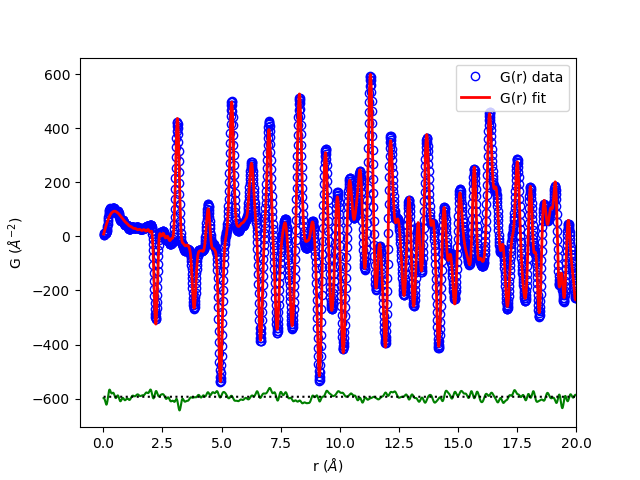

<IPython.core.display.Javascript object>


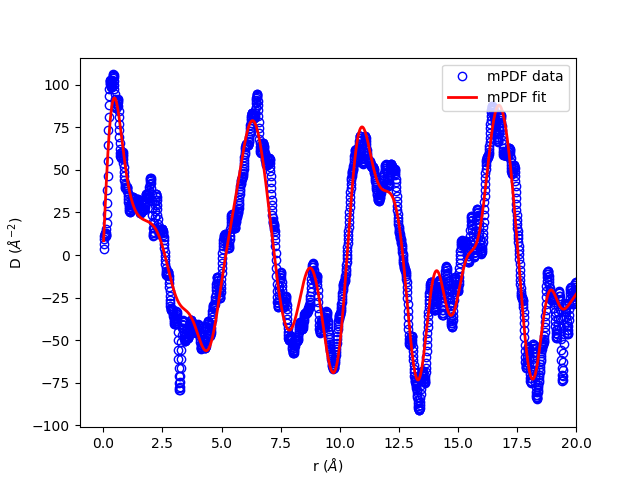

In [7]:
r = mnofit.totpdf.profile.x
gobs = mnofit.totpdf.profile.y

# Get the calculated PDF and compute the difference between the calculated and
# measured PDF
gcalc = mnofit.totpdf.evaluate()
gnuc = mnofit.totpdf.evaluateEquation('nucscale * nucpdf')
gmag = mnofit.totpdf.evaluateEquation('mpdf')

baseline = 1.1 * gobs.min()
gdiff = gobs - gcalc
baseline2 = 1.1 * (gdiff+baseline).min()

# Plot the best-fit total PDF
ax=plt.figure().add_subplot(111)
ax.plot(r, gobs, 'bo', label="G(r) data", markerfacecolor='none', markeredgecolor='b')
ax.plot(r, gcalc, 'r-', lw=2, label="G(r) fit")
ax.plot(r, gdiff + baseline,'g-')
ax.plot(r, np.zeros_like(r) + baseline, 'k:')
ax.set_xlabel(r"r ($\AA$)")
ax.set_ylabel(r"G ($\AA^{-2}$)")
ax.set_xlim(xmax=mc.rmax)
plt.legend()

plt.show()


# Plot just the mPDF
ax=plt.figure().add_subplot(111)
ax.plot(r, gobs-gnuc, 'bo', label="mPDF data", markerfacecolor='none', markeredgecolor='b')
ax.plot(r, gmag, 'r-', lw=2, label="mPDF fit")
ax.set_xlabel(r"r ($\AA$)")
ax.set_ylabel(r"D ($\AA^{-2}$)")
ax.set_xlim(xmax=mc.rmax)
plt.legend(loc=1)

plt.show()

In [ ]:
plt.close('all')